# EEG Pipeline Tutorial

In this notebook, we will demonstrate how to use the newly implemented EEG pipeline of CMP3, using the "VEPCON" dataset, available at https://openneuro.org/datasets/ds003505/versions/1.1.0. 

It is important to note that CMP3 _does not_ include preprocessing of EEG data, so it is expected that you have your data ready to be analyzed. 

.. nbinfo:: **Important:** Note that the skull-surfaces provided with the dataset ("bem", see below) which are needed to create the head model are obtained from non-defaced MRIs. You will not be able to proceed with surfaces created from VEPCON dataset alone.

## Setup instructions

If you want to reproduce all the results of this notebook on your side, a conda ``environment.yml`` file can be downloaded at the following link: [EEG_tutorial_environment.yml](EEG_tutorial_environment.yml). The original ``.ipynb`` notebook file can be downloaded at the following link: [EEG_pipeline_tutorial.ipynb](https://github.com/connectomicslab/connectomemapper3/raw/master/docs/notebooks/EEG_pipeline_tutorial.ipynb).

Once you have downloaded the conda environment file, install the environment `py37cmp-eeg` as follows:
```bash
$ conda create env -f /path/to/downloaded/EEG_tutorial_environment.yml
```
This will install all the packages needed to run this notebook including jupyter lab.

You can then activate it, go to the directory where you downloaded the ``EEG_pipeline_tutorial.ipynb``, and launch jupyter lab as follows:

```bash
$ cd /directory/of/downloaded/EEG_pipeline_tutorial.ipynb
$ conda activate py37cmp-eeg
$ jupyter lab
```

You are ready to open and interact with the notebook!

## Loading the python packages used in the notebook

In [1]:
# General
import sys
import os
import argparse
import subprocess
import pdb
import pickle
import shutil
import json
from IPython.display import SVG, display
import warnings

# Dataset management
import datalad.api as dl

# Data handling and visualization
import numpy as np
import matplotlib.pyplot as plt

# BIDS import
from bids import BIDSLayout

# MNE imports
import mne
import mne_connectivity as mnec

# CMP3 imports
import cmp.project
from cmp.info import __version__, __copyright__
from cmtklib.util import print_error, print_blue, print_warning
from cmtklib.bids.io import __nipype_directory__, __cartool_directory__, __eeglab_directory__, __cmp_directory__

# other
from EEG_tutorial_utils import create_trans_files

## Loading the BIDS dataset

For demonstration, we are going to use the latest version of VEPCON dataset, available on [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.1.1)
that already contains outputs from Connectome Mapper v3.0.3 and Freesurfer 7.1.1. A full description of the dataset can be found in [Pascucci, Tourbier, et al. 2022].

In case you want to rerun the notebook, make sure to remove any `ds003505_demo` folder in the directory of the notebook. Otherwise, datalad install will complain.

[Pascucci, Tourbier, et al. 2022]: https://doi.org/10.1038/s41597-021-01116-1

In [2]:
%%time
# Download example dataset with datalad
bids_dir = os.path.join(".", "ds003505_demo")  # Adjust path to your BIDS dataset as needed
vepcon_data = dl.install(
    path=bids_dir,
    source="git@github.com:OpenNeuroDatasets/ds003505.git"
)

[INFO] Cloning dataset to Dataset(/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo) 
[INFO] Attempting to clone from git@github.com:OpenNeuroDatasets/ds003505.git to /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo 
[INFO] Start enumerating objects 
[INFO] Start counting objects 
[INFO] Start compressing objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo) 
[INFO] scanning for annexed files (this may take some time) 
[INFO] Unable to parse git config from origin 
[INFO] [ERROR] BrokenPipeError([Errno 32] Broken pipe) (BrokenPipeError) 
[INFO] Remote origin does not have git-annex installed; setting annex-ignore 
[INFO] This could be a problem with the git-annex installation on the remote. Please make sure that git-annex-shell is available in PATH when you s

CPU times: user 166 ms, sys: 109 ms, total: 275 ms
Wall time: 16.2 s


## Running the EEG pipeline

As of now, the EEG pipeline can only be run directly from the application programming interface (API) as demonstrated in this notebook. As soon as possible, we will integrate it into the graphical user interface (GUI) and the command line interface (CLI).

First, we need to configure the following user-defined arguments. Please modify them as needed.

In [3]:
# Adjust path to your BIDS dataset as needed
bids_dir = vepcon_data.path 

# Adjust path of the output directory as needed
output_dir = os.path.join(bids_dir, 'derivatives')

# Adjust the subject to be processed as needed
participant_label = 'sub-20'

# Adjust path to the anatomical pipeline configuration file as needed
anat_pipeline_config = os.path.join('.', 'ref_anatomical_config.json') 

# Adjust path to the MNE-based pipeline configuration file as needed
eeg_pipeline_config =  os.path.join('.', 'ref_mne_eeg_config.json')

The eeg pipeline config .json file contains information that CMP3 needs to correctly load EEG data and associated information like electrode positions, names of conditions, which parcellation to use, etc. as seen below:

In [4]:
%cat ref_mne_eeg_config.json

{
    "Global": {
        "process_type": "eeg",
        "subjects": [
            "sub-01"
        ],
        "subject": "sub-01",
        "version": "v3.0.0"
    },
    "eeg_preparer_stage": {
        "eeg_format": ".set",
        "epochs": "sub-01_task-faces_desc-preproc_eeg.set",
        "invsol_format": "mne-sLORETA",
        "parcellation": {
            "label": "lausanne2018", 
            "desc": "",
            "suffix": "scale1"
        },        
        "number_of_threads": 1,
        "EEG_params": {
            "expe_name": "faces",
            "EEG_event_IDs": {
            "SCRAMBLED" : 0,
            "FACES" : 1 
            },
            "start_t": -0.2, 
            "end_t" : 0.6
        }
    },
    "eeg_inverse_solution_stage": {
        "eeg_format": ".set",
        "number_of_threads": 1
    },
​
    "Multi-processing": {
        "number_of_cores": 1
    }
}


.. nbinfo:: **Note:** If you would like to run another subject (all available subjects except subjects 5 and 15 can be run), you will need to modify the config files (replacing `sub-<label>` accordingly).

Then, we need to tell datalad to download the actual content of the structural MRI and EEG files that will be input to the pipelines.

In [7]:
%%time
vepcon_data.get(f'{participant_label}/')
vepcon_data.get(f'derivatives/cmp-v3.0.3/{participant_label}/anat/')
vepcon_data.get(f'derivatives/freesurfer-7.1.1/{participant_label}/')
vepcon_data.get(f'derivatives/{__cartool_directory__}/{participant_label}/' +
                f'eeg/{participant_label}_eeg.xyz')

CPU times: user 16.1 ms, sys: 27.3 ms, total: 43.3 ms
Wall time: 1.77 s


[{'type': 'file',
  'refds': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo',
  'status': 'ok',
  'path': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cartool-v3.80/sub-20/eeg/sub-20_eeg.xyz',
  'action': 'get',
  'annexkey': 'MD5E-s6781--45eabac2296bdc04fcf4e907d602b471.xyz',
  'message': 'from s3-PUBLIC...'}]

Once the files are available, we need to configure a new CMP3 project.

In [8]:
# initialize project
project = cmp.project.ProjectInfo()
project.base_directory = os.path.abspath(bids_dir)
project.output_directory = os.path.abspath(output_dir)
project.subjects = ["{}".format(participant_label)]
project.subject = "{}".format(participant_label)
# anatomical pipeline is always run
project.anat_config_file = os.path.abspath(anat_pipeline_config)
# in our case, we do not have sessions
project.subject_sessions = [""]
project.subject_session = ""
# check for BIDS layout
bids_layout = BIDSLayout(project.base_directory)

Once set, we can run the anatomical pipeline, in order to obtain, among other things, Freesurfer derivatives necessary for the MNE pipeline.

Freesurfer and CMP3 derivatives are indeed provided with the VEPCON dataset, so we do not need to run it, but if run on a fresh dataset, it can take several hours (per subject). 

In [10]:
%%time
# Do not run again the anatomical pipeline
# You will have to set it to True on a fresh dataset
run = False  

# Initialize the anatomical pipeline reading the configuration file
anat_pipeline = cmp.project.init_anat_project(project, False)

if anat_pipeline is not None:
    # Check if inputs to anatomical pipeline are valid
    anat_valid_inputs = anat_pipeline.check_input(bids_layout, gui=False)
    if anat_valid_inputs:
        if run:
            print(">> Process anatomical pipeline")
            anat_pipeline.process()
    else:
        print_error("  .. ERROR: Invalid inputs")
        exit_code = 1

# Check if outputs to anatomical pipeline are valid
anat_valid_outputs, msg = anat_pipeline.check_output()

# Set the freesurfer subjects directory and the subject id
project.freesurfer_subjects_dir = anat_pipeline.stages['Segmentation'].config.freesurfer_subjects_dir
project.freesurfer_subject_id = anat_pipeline.stages['Segmentation'].config.freesurfer_subject_id

  .. LOAD: Load anatomical config file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ref_anatomical_config.json
  .. WARNING: CMP3 version used to generate the configuration files (v3.0.0)  and version of CMP3 used (v3.0.3) differ
**** Check Inputs  ****
> Looking in /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo for....
/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-20/anat/sub-20_T1w.nii.gz
... t1_file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-20/anat/sub-20_T1w.nii.gz
/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-20/anat/sub-20_T1w.json
... t1_json_file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-20/anat/sub-20_T1w.json
Inputs check finished successfully. 
Only anatomical data (T1) available.
  .. INFO: Valid derivati

In VEPCON, the electrode positions are provided in a file in the Cartool-derivatives folder, but CMP3 expects them in the EEGLAB-derivatives folder.

In [11]:
# Copy the file to the appropriate location
cartool_file_location = os.path.join(
    bids_dir, 'derivatives', __cartool_directory__,
    participant_label,'eeg', participant_label + '_eeg.xyz'
)
eeglab_file_location = os.path.join(
    bids_dir, 'derivatives', 'eeglab-v14.1.1',
    participant_label,'eeg', participant_label + '_eeg.xyz')

if not os.path.exists(eeglab_file_location):
    _ = shutil.copyfile(cartool_file_location, eeglab_file_location)

Since we are using non-defaced MRIs, which are not exactly the same as the ones provided on OpenNeuro, we need an additional transform that will be applied to the electrode positions.

In [12]:
# The following line creates the appropriate file with this transform in derivatives/cmp-v3.0.3:
create_trans_files(bids_dir, participant_label)

Finally, you can run the EEG pipeline.

In [14]:
%%time
# Set the path to the EEG pipeline configurration file
project.eeg_config_file = os.path.abspath(eeg_pipeline_config)

if anat_valid_outputs:
    # Initialize the EEG pipeline reading the configuration file and check input validity
    eeg_valid_inputs, eeg_pipeline = cmp.project.init_eeg_project(project, bids_layout, False)
    if eeg_pipeline is not None:
        eeg_pipeline.parcellation_scheme = anat_pipeline.parcellation_scheme
        eeg_pipeline.atlas_info = anat_pipeline.atlas_info

        if eeg_valid_inputs:
            print(">> Process EEG pipeline")
            eeg_pipeline.process()
        else:
            print("  .. ERROR: Invalid inputs")
            exit_code = 1
else:
    print_error(f'  .. ERROR: Invalid anatomical outputs for eeg pipeline')
    print_error(f'{msg}')
    exit_code = 1

**** Check Inputs is still not implemented ****
  .. LOAD: Load eeg config file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ref_mne_eeg_config.json
  .. WARNING: CMP3 version used to generate the configuration files (v3.0.0)  and version of CMP3 used (v3.0.3) differ
>> Process EEG pipeline
220218-18:23:08,484 nipype.interface INFO:
	 **** Processing ****
220218-18:23:14,228 nipype.workflow INFO:
	 Generated workflow graph: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-20/eeg_pipeline/graph.svg (graph2use=colored, simple_form=True).


/bin/sh: sysctl: command not found


ValueError: could not convert string to float: 

## A closer look at the EEG pipeline outputs

Let's have a closer look at the outputs that the EEG pipeline produces.

First of all: Connectomemapper works in such a way that the pipeline is first assembled and only afterwards, it is executed. During the assembly stage, input and output variables are connected and CMP3 produces a graph that visualizes this. 

In [ ]:
%matplotlib inline
path_to_svg = os.path.join(output_dir,__nipype_directory__,participant_label,'eeg_pipeline','graph.svg')
display(SVG(filename=path_to_svg))

Apart from the input ("datasource") and output ("eeg sinker") nodes that are apart, you can see three blue boxes that represent the stages of the pipeline flow:

    * Preparer stage
    * Loader stage
    * Inverse solution stage

Each of the stages, again, has an input and and output node, as well as several nodes representing processing steps. Each processing step has its own "interface" which you can find in ``cmtklib/interfaces`` ("mne" in parentheses indicates that they are defined in the file mne.py).

In the following, we will go over the interfaces and show what output they produce. 

### Preparer stage

Let's first have a look at the information given by the config file regarding this stage: 

>     "eeg_preparer_stage": {
        "eeg_format": ".set",
        "epochs": "sub-01_task-faces_desc-preproc_eeg.set",
        "invsol_format": "mne-sLORETA",
        "parcellation": {
            "label": "lausanne2008", 
            "desc": "",
            "suffix": "scale1"
        },        
        "number_of_threads": 1,
        "EEG_params": {
            "expe_name": "faces",
            "EEG_event_IDs": {
            	"SCRAMBLED" : 0,
            	"FACES" : 1 
            	},
            "start_t": -0.2, 
            "end_t" : 0.6
        }
    },


The preparer stage has three processing steps: 

- `eeglab2fif`: reads eeglab data and converts them to MNE format (.fif file extension)
- `createsrc`: creates the dipole locations along the surface of the brain 
- `createbem`: creates the boundary element method

#### eeglab2fif

If your data are not already in MNE format (`.fif` file extension), they have to be read and re-saved. The eeglab2fif interface does this for EEGLAB-format data (`.set` file extension). The interface produces a file named `sub-01_epo.fif` in the `derivatives/cmp-v3.0.3` folder. Critically, the saved epochs contain a montage, i.e. the sensor locations which have to be supplied in a file names `sub-01.xyz` inside the subject's EEGLAB derivatives folder (`derivatives/eeglab/sub-01/eeg/sub-01.xyz`). 

In [ ]:
# Let's have a look at the EEG data
with warnings.catch_warnings(): # suppress some irrelevant warnings coming from mne.read_epochs_eeglab()
    warnings.simplefilter("ignore")
    epochs_eeglab = mne.read_epochs_eeglab(os.path.join(output_dir,__eeglab_directory__,\
                                participant_label,'eeg',participant_label+'_task-faces_desc-preproc_eeg.set')) # sub-01_FACES_250HZ_prepd.set

# eeglab2fif removes a baseline and crops the epochs according to parameters start_t and end_t in config file
start_t = -0.2
end_t = 0.6
epochs_eeglab.apply_baseline((start_t,0))
epochs_eeglab.crop(tmin=start_t,tmax=end_t)
evoked_eeglab = epochs_eeglab.average().pick('eeg')

# compare to what eeglab2fif saved
epochs_mne = mne.read_epochs(os.path.join(output_dir,__cmp_directory__,\
                                participant_label,'eeg',participant_label+'_epo.fif'))
evoked_mne = epochs_mne.average().pick('eeg')

In [ ]:
# plot and convince yourself it's the same
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_=evoked_mne.plot(time_unit='s')

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_=evoked_eeglab.plot(time_unit='s')

#### createsrc

MNE is able to create volume- and surface-based source spaces, but in our pipeline, we use surface-based only. In order to do this, MNE takes advantage of the Freesurfer-created outputs in the `derivatives/freesurfer-7.1.1` derivatives directory. 

#### createbem

The BEM (boundary element model) is the head model we use, in our case, it is based on the individual's structural MRI and, again, related freesurfer derivatives. Its creation consists of two steps:

1. The necessary surfaces (brain, inner skull, outer skull, and outer skin) are extracted using ``mne.bem.make_watershed_bem()``. The surfaces are saved in the subject's freesurfer-directory in a new folder `bem/` watershed.

2. The model itself is created using ``mne.make_bem_model()`` and ``mne.make_bem_solution()``. In this step, the surfaces and the tissue conductivities between the surfaces are used. 

In [ ]:
# Let's visualize the BEM surfaces and source space
src = mne.read_source_spaces(os.path.join(output_dir,__cmp_directory__,\
                                participant_label,'eeg',participant_label+'_src.fif'))
# plot will appear in separate window
%matplotlib qt 
# lines are the surfaces, pink dots are the sources (dipoles)
_=mne.viz.plot_bem(subject=participant_label, subjects_dir=project.freesurfer_subjects_dir,
                 brain_surfaces='white', src=src, orientation='sagittal')

### Loader stage

During the preparer stage, we have told CMP3 which file extensions and keywords to look for that are going to be used in the actual inverse solution. Using nipype's "BIDS datagrabber", it gathers the necessary inputs in this step. 

### Inverse solution stage

The only implemented inverse solution algorithm right now is sLORETA. 

This stage has again three processing steps: 

- `createfwd`: creates the forward solution (leadfield) from the BEM and the source space
- `createcov`: creates the noise covariance matrix from the data
- `invsol_MNE`: creates the actual inverse operator and applies it, resulting in ROI-time courses

#### createfwd

MNE first computes a forward solution that describes how electrical currents propagate from the sources created earlier (via createsrc) through the tissues of the head modelled by the BEM (created via createbem) to the electrodes. Thus, the electrode positions have to be known and be aligned to the head model. 

In [ ]:
# Let's check the alignment between MRI and electrode positions.
trans = mne.read_trans(os.path.join(output_dir,__cmp_directory__,\
                                participant_label,'eeg',participant_label+'-trans.fif'))
mne.viz.plot_alignment(epochs_mne.info, trans=trans, subject=participant_label,
                       subjects_dir=project.freesurfer_subjects_dir, dig=False,
                       surfaces=dict(head=0.95), coord_frame='mri')

#### createcov

MNE uses an estimate of signal to noise ratio in its creation of the inverse solution. For that, it considers the pre-stimulus period of the EEG recordings.

In [ ]:
# Let's have a look at the noise covariance.
%matplotlib inline
noise_cov = mne.read_cov(os.path.join(output_dir,__cmp_directory__,\
                                participant_label,'eeg',participant_label+'_noisecov.fif'))
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, epochs_mne.info)

#### invsol_MNE

Now, everything comes together to create the inverse operator, which is then applied to the EEG data to create source time courses. In the last step, the source time courses are converted to ROI-time courses according to the selected parcellation. 

The outputs that are necessary for this step to work were created in the previous processing steps, namely: 

- the EEG epochs in .fif-format
- the electrode montage
- the head model
- the source point locations
- the forward operator
- the noise covariance

First, the inverse operator is created using ``mne.minimum_norm.make_inverse_operator()``. We use the options 

```
loose=1, depth=None, fixed=False
```

This means that we are obtaining full 3-dimensional dipoles whose orientation is not fixed or constrained to be (somewhat) orthogonal to surface; and we are not applying any depth weighting. The solution is written to a file `sub-01-inv.fif` in the same directory as the other outputs (`derivatives/cmp-v3.0.3/sub-01/eeg`). 

In a subsequent step in the same interface, this inverse operator is then applied to the epochs (not the evoked time course averaged over trials) using mne.minimum_norm.apply_inverse_epochs. 

The final step performed by this interface and by the EEG pipeline is to use mne.extract_label_time_course to create ROI-time courses according to ``mne.read_labels_from_annot()``. As given in the config file, we use "lausanne2008" scale 1, which is the Desikan-atlas. The time courses and the ROI-names are stored in ``sub-01_rtc_epo.pkl``, i.e. a format that is not specific to MNE.

Let's have a look at the time courses.

In [ ]:
with open(os.path.join(output_dir,__cmp_directory__,participant_label,'eeg',participant_label+'_rtc_epo.pkl'),'rb') as f:
    rtc_epo = pickle.load(f)
    # for some reason, MNE writes label time courses as lists. convert to numpy array
    rtc_epo['data'] = np.array(rtc_epo['data'])

In [ ]:
# sort labels to make the time courses look nicer
N = len(rtc_epo['labels'])-2 # two "unknown" regions - do not plot
sorting = list(np.arange(0,N,2))+list(np.arange(1,N,2)) # left and right always alternating
# list of ROI names
labels_list_left = [i.name for i in rtc_epo['labels'][0::2] if i.name!='unknown -lh']
labels_list_right = [i.name for i in rtc_epo['labels'][1::2] if i.name!='unknown -rh']
labels_list = labels_list_left+labels_list_right

In [ ]:
# plot
%matplotlib inline
to_plot = np.mean(rtc_epo['data'][:,:-2,:],axis=0)
vminmax = np.max(abs(to_plot))
plt.rcParams['figure.figsize'] = (15, 10)
plt.imshow(to_plot[sorting,:],aspect='auto',extent=[-200,600,0,67],interpolation='None',vmin=-vminmax,vmax=vminmax,cmap='PiYG');
plt.xlabel('ms')
plt.ylabel('ROIs')
cbar = plt.colorbar()
cbar.set_label('source activity (a.u.)')
locs = np.arange(0,N)
_=plt.yticks(locs,labels_list[-1::-1] )  

We can see that some of the time courses are "flipped" (have the opposite sign of the others). We will not address this problem here, but this is because of the step where dipole time courses are summarized for each brain region, using PCA. The direction of the resulting vector is not uniquely defined. 

## Connectivity measures

Of course, the idea of CMP3 is to provide connectomes! This interface is not implemented yet in the pipeline, but with the ROI-time courses, it is easy to obtain functional connectivity matrices using MNE functions. 

Keep in mind that we only plot a single subject's connectivity here, so it is not surprising if you do not see exactly what you would expect. 

In [ ]:
%%time
sfreq = epochs_mne.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']

label_ts = rtc_epo['data']

con = mnec.spectral_connectivity(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq,
    faverage=True, mt_adaptive=True, n_jobs=1)

# Save the weighted connectome file according to the naming convention of CMP3
#for idx,con_method in enumerate(con_methods):
#    con_output_fname = os.path.join(
#        output_dir,
#        __cmp_directory__,
#        participant_label,
#        'eeg',
#        f'{participant_label}_atlas-L2018_res-scale1_conndata-network_connectivity{con_method}.nc'
#    )
#    con[idx].save(con_output_fname)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output='dense')[:, :, 0]

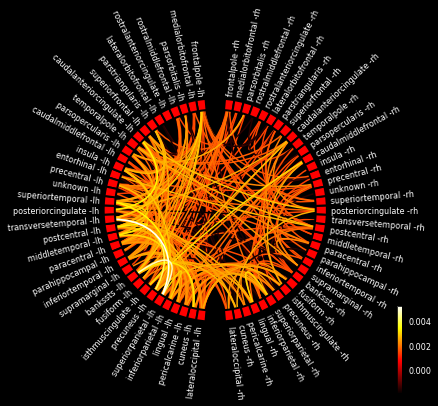

(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [ ]:
%%time
label_names = [label.name for label in rtc_epo['labels']]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(rtc_epo['labels'][idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = mnec.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
# plot will appear in separate window
%matplotlib inline 
mnec.viz.plot_connectivity_circle(con_res['wpli2_debiased'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors='r',
                         title='')

This concludes the tutorial.